In [1]:
!pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.5/696.5 kB 16.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import neurokit2 as nk
import json
import os

In [3]:
# import os
# import mne
# import numpy as np
# import pandas as pd
# from scipy.signal import find_peaks

# mne.set_log_level('WARNING')

# all_data = []

# def extract_periods(signal, distance_sec, sfreq, num_periods=5):
#     # Find peaks
#     peaks, _ = find_peaks(signal, distance=int(distance_sec * sfreq * 0.8))
#     if len(peaks) < num_periods + 1:
#         raise ValueError("Not enough peaks to extract the required number of periods.")
    
#     periods = []
#     for i in range(num_periods):
#         start = peaks[i]
#         end = peaks[i+1]
#         periods.append(signal[start:end])
#     return periods

# def process_files(folder_path, label):
#     file_names = os.listdir(folder_path)
#     for file_name in file_names:
#         if file_name.endswith('.edf'):
#             try:
#                 file_path = os.path.join(folder_path, file_name)
#                 data = mne.io.read_raw_edf(file_path, preload=True)
                
#                 raw_data = data.get_data()
#                 channels = data.ch_names
#                 sfreq = data.info['sfreq']
                
#                 ecg_channels = ['ECG I', 'ECG II', 'ECG V1', 'ECG V2', 'ECG V3', 'ECG V4', 'ECG V5', 'ECG V6']
                
#                 missing_channels = [ch for ch in ecg_channels if ch not in channels]
#                 if missing_channels:
#                     print(f"File {file_path} is missing channels: {missing_channels}")
#                     continue
                
#                 ecg_processed = []
#                 ecg_pieces = []
#                 for ch in ecg_channels:
#                     channel_data = raw_data[channels.index(ch)]
#                     channel_data = (channel_data - np.mean(channel_data)) / np.std(channel_data)
                    
#                     try:
#                         periods = extract_periods(channel_data, distance_sec=0.6, sfreq=sfreq, num_periods=5)
                        
#                         for period in periods:
#                             ecg_pieces.append(period)
#                     except Exception as e:
#                         print(f"Could not extract periods from {file_name} channel {ch}: {e}")

#                 if ecg_pieces:
#                     ecg_signal = np.hstack(ecg_pieces)
#                     all_data.append({'signal': ecg_signal.tolist(), 'label': label})
                
#             except Exception as e:
#                 print(f'Error with file {file_name}: {e}')
#                 continue

# # Process Amy files (label 1)
# process_files(folder_path='/kaggle/input/finetuning-dataset/LFV', label=1)

# # Process noAMY files (label 0)
# process_files(folder_path='/kaggle/input/finetuning-dataset/noLFV', label=0)

# # Create final DataFrame
# df = pd.DataFrame(all_data)

# # Save to ecg_train.csv
# df.to_pickle('ecg_tune.pkl')

# print("Successfully whatever!")

In [4]:
# maxm = 0
# for i in range (104000):
#     if np.int32(df.iloc[i, 0].shape[0]) > maxm:
#         maxm = df.iloc[i, 0].shape
# print(maxm)

In [5]:
# df = pd.read_pickle('/kaggle/input/finetuning-dataset/heartbeats.pkl')
# # df.shape
# n = np.linspace(0, 100, len(df.iloc[150][0]))
# plt.plot(n, df.iloc[150][0])

In [6]:
df = pd.read_pickle('/kaggle/input/finetuning-dataset/ecg_tune.pkl')
df.shape

(1816, 2)

In [7]:
df.head()

,signal,label
0,"[0.042232577986440104, 0.0470670537923487, 0.0...",1
1,"[-0.02575025164205102, -0.02504170821938366, -...",1
2,"[-0.01787115710559064, -0.016211404883840905, ...",1
3,"[-0.009995051078367553, -0.0077472439476526725...",1
4,"[-0.07244506616318022, -0.07452869741081661, -...",1


In [8]:
total_db_new = df[df['label']==0].head(0)
for i in range(2):
 total_db_new = pd.concat([total_db_new,df[df['label']==i].sample(n=908)],ignore_index=True)
# total_db_new = df

In [9]:
def resample_signal(row):
    original_signal = row['signal']
    resampled_signal = nk.signal_resample(original_signal, sampling_rate=500, desired_sampling_rate= 250, method="FFT")
    return pd.Series({'signal': resampled_signal, 'label': row['label']})

In [10]:
resampled_df = total_db_new.apply(resample_signal, axis=1)
del total_db_new
total_db_new = resampled_df

# Split and Normalization

In [11]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(total_db_new, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=(2/3), random_state=42)

train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [12]:
def find_max_min(current_df):
  min_value = current_df['signal'].apply(lambda x: min(x)).min()
  max_value = current_df['signal'].apply(lambda x: max(x)).max()
  return min_value, max_value

min_train_df, max_train_df = find_max_min(train_df)
print(min_train_df, max_train_df)

min_val_df, max_val_df = find_max_min(val_df)
print(min_val_df, max_val_df)

min_test_df, max_test_df = find_max_min(test_df)
print(min_test_df, max_test_df)

-5.209034011979457 3.5960230349333737
-3.15710969772702 2.862462871404692
-3.8223723399745015 3.0604428310767835


In [13]:
train_df['signal'] = train_df['signal'].apply(lambda x: [(item - min_train_df) / (max_train_df - min_train_df) for item in x])

val_df['signal'] = val_df['signal'].apply(lambda x: [(item - min_val_df) / (max_val_df - min_val_df) for item in x])

test_df['signal'] = test_df['signal'].apply(lambda x: [(item - min_test_df) / (max_test_df - min_test_df) for item in x])


#Quantization


In [14]:
# from https://github.com/joaomrcarvalho/diffquantizer.git

class DiffQuantizer:
    def __init__(self, alphabet_size, average_over=1, filter=False, breakpoints=None, use_diffs=True):

        self.alphabet_size = alphabet_size
        self.average_over = average_over
        self.use_filter = filter
        self.breakpoints = breakpoints
        self.use_diffs = use_diffs
        # print('self.breakpoints:',self.breakpoints)

    def preprocess(self, tmp):
        if self.average_over != 1:
            tmp = self._average_over_n(tmp, self.average_over)

        if self.use_filter:
            tmp = self._filter_signal(tmp)

        if self.use_diffs:
            tmp = self._diff_signal(tmp)

        return tmp

    def perform_quantization(self, tmp, breakpoints=None):
        self.breakpoints = breakpoints
        # print('perform_quantization, self.breakpoints:',self.breakpoints)
        tmp = self.preprocess(tmp)
        result = self._quantize_with_breakpoints(tmp)
        return result

    def learn_breakpoints(self, arr):
        res = self.preprocess(arr)

        sorted_array = np.sort(res)

        length = len(sorted_array)

        probs = [1 / self.alphabet_size for _ in range(self.alphabet_size)]
        cum_sum_breakpoints = [int(sum(probs[0:i + 1]) * length - 1) for i in range(len(probs))]
        cum_sum_breakpoint_values = sorted_array[cum_sum_breakpoints]

        cum_sum_breakpoint_values[-1] = 1e+100

        self.breakpoints = cum_sum_breakpoint_values
        # print('learn_breakpoints,self.breakpoints',self.breakpoints)

        return cum_sum_breakpoint_values

    # vectorized use
    @staticmethod
    def _breakpoint_to_letter(float_num, breakpoints):
        # print('float_num:',float_num,'breakpoints:',breakpoints)
        # print(list((breakpoints.index(obj) for obj in breakpoints if float_num < obj)))
        int_val = next((breakpoints.index(obj) for obj in breakpoints if float_num < obj))
        # print(int_val,list((breakpoints.index(obj) for obj in breakpoints if float_num < obj)))
        # A + int_val
        return chr(65 + int_val)

    def _quantize_with_breakpoints(self, tmp):
        breakpoints = self.breakpoints
        vect_breakpoint_to_letter = np.vectorize(self._breakpoint_to_letter, excluded=['breakpoints'])
        # print(tmp,breakpoints,self._breakpoint_to_letter,vect_breakpoint_to_letter)
        tmp = vect_breakpoint_to_letter(tmp, breakpoints=list(breakpoints))
        # tmp = vect_breakpoint_to_letter(tmp, breakpoints=breakpoints)
        return tmp

    @staticmethod
    def _read_csv_file(input_file):
        tmp_file_content = pd.read_csv(input_file, sep="\n", header=None, dtype=np.float64)
        return np.array(tmp_file_content)

    ## @staticmethod
    # def _filter_signal(tmp):
    #     return butter_lowpass_filter(tmp)

    @staticmethod
    def _average_over_n(tmp, n):
        return np.array([np.average(tmp[i:i + n]) for i in range(0, len(tmp), n)])

    @staticmethod
    def _diff_signal(tmp):
        res = np.diff(tmp)
        return np.insert(res, 0, 0.0)

In [15]:
import math
import csv

class Preprocessing():

  def __init__(self, input_file, discretizition_factor, max_window_size):
    self.input_file = input_file
    self.discretizition_factor = discretizition_factor
    self.max_window_size = max_window_size


  def create_window(self):

    ecg_window = [] #ecg_window: list of windows

    mlen=0
    ecg_list = self.input_file['signal']
    if len(ecg_list) > mlen:
      mlen= len(ecg_list)

    if mlen > self.max_window_size:
      window_size = self.max_window_size
    else:
      window_size = mlen

    num_lines = math.floor(len(ecg_list)/window_size) #in this case: 1

    for i in range(num_lines):
      tmp_list = ecg_list[i*window_size:(i+1)*window_size]
      ecg_window.append(tmp_list)

    return ecg_window

  def change_to_alphabet(self, quantizer, normalized_list):
    qtz_signal = []
    labels = []
    qtz = quantizer
    for i in range(len(normalized_list)): #i is for each line
      r = qtz.perform_quantization(np.array(normalized_list[i]),breakpoints=qtz.breakpoints)
      # print('result:',r.shape)
      # make r from list of chars  to string a chars by ''.joint(r)
      qtz_signal.append(''.join(r))
      labels.append(self.input_file['label'])

    return qtz_signal, labels

In [16]:
### lloyd_max
def discretization_lloyd_max(discretizition_factor, total_data):
  qtz_signal = []
  labels = []
  qtz=DiffQuantizer(alphabet_size=discretizition_factor,breakpoints=None,use_diffs=False)
  qtz.learn_breakpoints(np.array(total_data))
  return qtz

In [17]:
def run_Preprocessing(db, max_window_size=4000, discretizition_factor=100):
    discretizition_factor = discretizition_factor
    max_window_size = max_window_size
    nl_list, total_data = [], []
    r_list, labels = [], []

    for n in range(len(db)):
      pre = Preprocessing(db.loc[n], discretizition_factor, max_window_size)
      nl = pre.create_window()
      nl_list.append(nl)

    for i in range(len(nl_list)):
        total_data.extend(nl_list[i][0])

    quantize_max_lloyd_on_total_data = discretization_lloyd_max(discretizition_factor, total_data)

    for n in range(len(db)):
      pre = Preprocessing(db.loc[n], discretizition_factor, max_window_size)
      nl = pre.create_window()
      r, l = pre.change_to_alphabet(quantize_max_lloyd_on_total_data, nl)
      r_list.extend(r)
      labels.extend(l)
    print(n, " : done")

    return r_list, labels

`check max_window_size`

In [18]:
r_list_train, labels_train = run_Preprocessing(db=train_df, max_window_size=4000, discretizition_factor=100)

r_list_val, labels_val = run_Preprocessing(db=val_df, max_window_size=4000, discretizition_factor=100)

r_list_test, labels_test = run_Preprocessing(db=test_df, max_window_size=4000, discretizition_factor=100)

1270  : done
180  : done
363  : done


In [19]:
len(r_list_train)

1271

# Tokenizer

In [20]:
from transformers import AutoTokenizer, AutoModel

In [21]:
tokenizer_ft = AutoTokenizer.from_pretrained(pretrained_model_name_or_path="/kaggle/input/pretrained_heartbert/transformers/pt20k_250/1/model")

In [22]:
def tokenize_function(examples, max_length = 512):
    return tokenizer_ft(examples, padding="max_length", truncation=True, max_length=max_length)

In [23]:
tokenized_dataset_train = list(map(tokenize_function, r_list_train))

tokenized_dataset_val = list(map(tokenize_function, r_list_val))

tokenized_dataset_test = list(map(tokenize_function, r_list_test))

In [24]:
len(tokenized_dataset_test)

364

## input_ids, attention_masks, labels

In [25]:
def return_ids(tokenized_dataset):

  dataset = []
  input_ids = []
  attention_masks = []

  for i in range(len(tokenized_dataset)):

      dataset.append(tokenized_dataset[i])
      del dataset[-1]['token_type_ids']

      input_ids.append(np.array(dataset[-1]['input_ids'], dtype=np.int32))

      attention_masks.append(np.array(dataset[-1]['attention_mask'], dtype=bool))

      dataset = []

  input_ids = np.array(input_ids)
  attention_masks = np.array(attention_masks)

  return input_ids, attention_masks

In [26]:
input_ids_train, attention_masks_train = return_ids(tokenized_dataset_train)

input_ids_val, attention_masks_val = return_ids(tokenized_dataset_val)

input_ids_test, attention_masks_test = return_ids(tokenized_dataset_test)

In [27]:
labels_train = np.array(labels_train,dtype=np.int8)

labels_val = np.array(labels_val,dtype=np.int8)

labels_test = np.array(labels_test,dtype=np.int8)

In [28]:
len(labels_test)

364

# DataLoader

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [31]:
bert_model = AutoModel.from_pretrained("/kaggle/input/pretrained_heartbert/transformers/pt20k_250/1/model")

2025-06-20 06:03:02.638321: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750399382.820257      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750399382.875548      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Some weights of RobertaModel were not initialized from the model checkpoint at /kaggle/input/pretrained_heartbert/transformers/pt20k_250/1/model and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
bert_model = bert_model.to(device)

In [33]:
bert_model.eval()

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(52000, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-5): 6 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (drop

In [34]:
for param in bert_model.parameters():
  param.requires_grad = False

In [35]:
batch_size = 8

In [36]:
dataset_ = TensorDataset(torch.tensor(input_ids_train), torch.tensor(labels_train),
                         torch.tensor(attention_masks_train))
dataloader = DataLoader(dataset_, batch_size=batch_size, shuffle = True)

In [37]:
dataset_valid = TensorDataset(torch.tensor(input_ids_val), torch.tensor(labels_val),
                          torch.tensor(attention_masks_val))
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle = True)

In [38]:
dataset_test = TensorDataset(torch.tensor(input_ids_test), torch.tensor(labels_test),
                          torch.tensor(attention_masks_test))
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle = False)

In [39]:
len(dataset_test)

364

# BertBiLSTMClassifier

In [40]:
class BertBiLSTMClassifier(nn.Module):
    def __init__(self, num_classes, bert_frozen_layers=3, input_size=768, lstm_hidden_size=128):
        # you can set bert_frozen_layers to an arbitrary number
        super(BertBiLSTMClassifier, self).__init__()

        # HeartBERT model with frozen layers
        self.bert = AutoModel.from_pretrained(pretrained_model_name_or_path="/kaggle/input/pretrained_heartbert/transformers/pt20k_250/1/model")

        modules = [self.bert.embeddings, *self.bert.encoder.layer[:bert_frozen_layers]]
        for module in modules:
          for param in module.parameters():
            param.requires_grad = False
        # Bi-LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=lstm_hidden_size, bidirectional=True, batch_first=True)

        # Fully connected layer for classification
        self.fc = nn.Linear(lstm_hidden_size * 2, 1)
        self.sigmoid = nn.Sigmoid()
      #  self.softmax = nn.Softmax(dim=1)
    

    def forward(self, input_ids):
        # BERT forward pass
        bert_output = self.bert(input_ids)[0]
        # Bi-LSTM forward pass
        lstm_out, _ = self.lstm(bert_output)
        # Use the last hidden state from Bi-LSTM
        lstm_last_hidden_state = lstm_out[:, -1, :]
        # Classification using fully connected layer
        logit = self.fc(lstm_last_hidden_state)
        res = self.sigmoid(logit)

      #  res = self.softmax(logits)

        return res.squeeze(-1)

In [41]:
model = BertBiLSTMClassifier(2)
model = model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at /kaggle/input/pretrained_heartbert/transformers/pt20k_250/1/model and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
trainable_params

22774017

In [43]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-6) # setup the proper lr
# lr=1e-6 40 epoch маловато, очень медленно, test loss 0.5638710278798552

# Metrics

In [44]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def compute_metrics(predictions, labels):
    # Преобразуем в бинарные предсказания (если нужно)
    predictions = (predictions > 0.5).cpu().numpy()
    labels = labels.cpu().numpy()
    
    # Вычисление метрик
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None, zero_division=0)
    accuracy = accuracy_score(labels, predictions)

    print("Class-wise Metrics:")
    for i in range(len(precision)):
        print(f"Class {i}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}")

    print("\nAccuracy:")
    print(f"Accuracy={accuracy:.4f}")

def display_confusion_matrix(eval_pred, labels):
    num_classes = 2

    predictions = eval_pred.cpu().numpy()  # Перенос на CPU и преобразование в numpy
    predictions = (predictions > 0.5).astype(int)  # Преобразование в 0 или 1

    # predictions = np.argmax(eval_pred, axis=-1)
    # predictions = eval_pred.cpu().numpy()
    # predictions = (predictions > 0.5).cpu().numpy()
    print(f"Length of predictions: {len(predictions)}")
    print(f"Length of labels: {len(labels)}")

    cm = confusion_matrix(labels, predictions)

    # Plot confusion matrix
    plt.figure(figsize=(num_classes*5, num_classes*5))

    sns.heatmap(cm, annot=True, fmt="d", cmap="RdPu", cbar=False,
                xticklabels=np.arange(1, num_classes+1),
                yticklabels=np.arange(1, num_classes+1))

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


In [45]:
# from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# def compute_metrics(eval_pred, labels):

#     predictions = np.argmax(eval_pred, axis=-1)

#     # Compute precision, recall, F1, and accuracy
#     precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None)
#     accuracy = accuracy_score(labels, predictions)

#     # Compute micro and macro averages
#     micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(labels, predictions, average='micro')
#     macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')

#     print("Class-wise Metrics:")
#     for i in range(len(precision)):
#         print(f"Class {i+1}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}")

#     print("\nMicro Average Metrics:")
#     print(f"Precision={micro_precision:.4f}, Recall={micro_recall:.4f}, F1={micro_f1:.4f}")

#     print("\nMacro Average Metrics:")
#     print(f"Precision={macro_precision:.4f}, Recall={macro_recall:.4f}, F1={macro_f1:.4f}")

#     print("\nAccuracy:")
#     print(f"Accuracy={accuracy:.4f}")

# def display_confusion_matrix(eval_pred, labels):
#     num_classes = 2

#     predictions = np.argmax(eval_pred, axis=-1)

#     cm = confusion_matrix(labels, predictions)

#     # Plot confusion matrix
#     plt.figure(figsize=(num_classes, num_classes))

#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
#                 xticklabels=np.arange(1, num_classes+1),
#                 yticklabels=np.arange(1, num_classes+1))

#     plt.xlabel('Predicted')
#     plt.ylabel('Actual')
#     plt.title('Confusion Matrix')
#     plt.show()


# Train

In [46]:
loss_epoch_train = []
loss_epoch_valid = []
num_epochs = 20

In [47]:
from numpy import mean
total_train_acc = np.zeros((num_epochs,))
total_valid_acc = np.zeros((num_epochs,))
for epoch in range(num_epochs):
  loss_batch_train = []
  correct_train = []
  correct_valid = []
  accuracy_train = []
  model.train()
  for batch in dataloader:

    inputs, labels, _ = batch

    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    # loss = criterion(outputs.to(device), labels.type(torch.LongTensor).to(device))
    labels = labels.to(device).float()  
    loss = criterion(outputs, labels)
    # predicted = torch.argmax(outputs.data, dim=1)
    predicted = (outputs > 0.5).long()
    correct_train.extend(predicted.eq(labels.to(device).data).float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_batch_train.append(loss.item())

  # if (epoch%10==0):
  #   torch.save(model.state_dict(), '/content/drive/MyDrive/'+str(epoch)+'.pt')

  total_train_acc[epoch] = torch.tensor(correct_train).mean().item()
  loss_train_per_epoch = mean(loss_batch_train)
  loss_epoch_train.append(loss_train_per_epoch)
  print('train-loss',epoch,':', loss_epoch_train[-1])

  model.eval()
  loss_batch_valid = []

  for batch in dataloader_valid:
    inputs, labels, _ = batch
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    # loss = criterion(outputs.to(device), labels.type(torch.LongTensor).to(device))
    labels = labels.to(device).float()  
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    # predicted = torch.argmax(outputs.data, dim=1)
    predicted = (outputs > 0.5).long()
    correct_valid.extend(predicted.eq(labels.to(device).data).float())
    loss_batch_valid.append(loss.item())

  total_valid_acc[epoch] = torch.tensor(correct_valid).mean().item()
  loss_valid_per_epoch = mean(loss_batch_valid)
  loss_epoch_valid.append(loss_valid_per_epoch)
  print(total_train_acc,total_valid_acc)
  print('valid-loss',epoch,':',loss_epoch_valid[-1])
  print('**********')


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


train-loss 0 : 0.6275501646710642
[0.6632573 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.       ] [0.79558009 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
valid-loss 0 : 0.5232454045959141
**********
train-loss 1 : 0.5774036972027905
[0.6632573  0.71675843 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ] [0.79558009 0.77900553 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
valid-loss 1 : 0.5001032417235167
**********
train-loss 2 : 0.5623352870626269
[0.6632573  0.7

In [48]:
print(total_train_acc,total_valid_acc)

[0.6632573  0.71675843 0.7136113  0.72856021 0.74272227 0.76475215
 0.77891421 0.79701024 0.82061368 0.84343034 0.84972465 0.87332809
 0.86546028 0.89063728 0.90086544 0.91660112 0.92682928 0.93391031
 0.95043272 0.94964594] [0.79558009 0.77900553 0.7845304  0.79005527 0.79558009 0.79005527
 0.8232044  0.80662984 0.81215471 0.80110496 0.81215471 0.77900553
 0.8232044  0.79558009 0.75690609 0.80662984 0.79005527 0.79005527
 0.80110496 0.80110496]


## Plot

In [49]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 16,
    'axes.titlesize': 16,
    'axes.labelsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
})

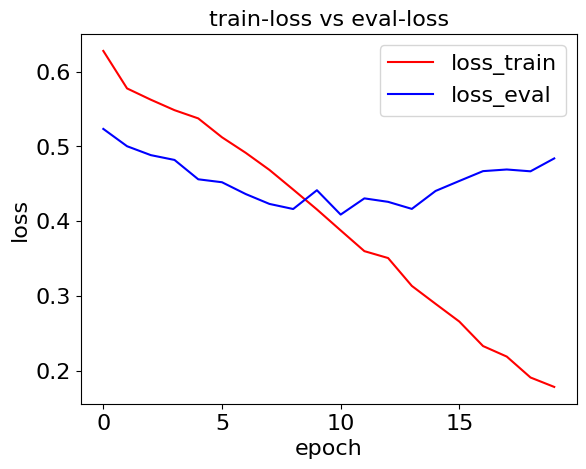

In [50]:
import matplotlib.pyplot as plt
plt.plot(loss_epoch_train,'r')
plt.plot(loss_epoch_valid,'b')
plt.title('train-loss vs eval-loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss_train','loss_eval']);

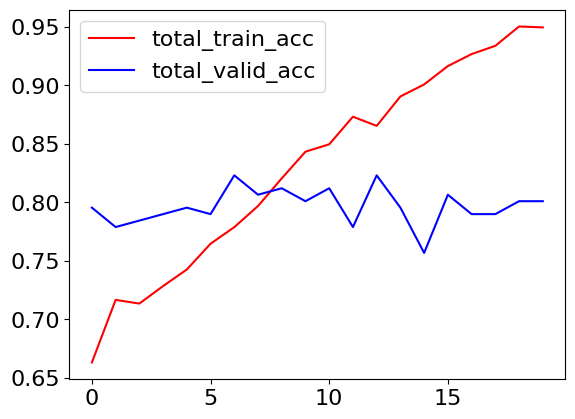

In [51]:
plt.plot(total_train_acc, 'r')
plt.plot(total_valid_acc, 'b')
plt.legend(['total_train_acc', 'total_valid_acc'])

In [52]:
torch.save(model,'/kaggle/working/model250.pt')
torch.save(model,'/kaggle/working/model2501.pth')

In [53]:
torch.save(model.state_dict(), '/kaggle/working/state_dict.pt')
torch.save(model.state_dict(), '/kaggle/working/state_dict1.pth')

In [54]:
# model_scripted = torch.jit.script(model) 
# model_scripted.save('/kaggle/working/model_scripted.pt')

# Test

In [55]:
model.eval()
loss_batch_test = []

# outputs_temp=torch.zeros((1,outputs.size()[1])).to(device)
outputs_temp=torch.zeros((1)).to(device)
labels_temp = torch.zeros((1,))

for batch in dataloader_test:
  with torch.no_grad():
    inputs, labels, _ = batch
    inputs = inputs.to(device)
    labels = labels.to(device)
    # attention = attention.type(torch.IntTensor).to(device)
    outputs = model(inputs)
    #predicted = torch.argmax(outputs.data)
    predicted = (outputs > 0.5).long()
    correct_train.extend(predicted.eq(labels.to(device).data).float())

  outputs_temp = torch.cat((outputs_temp,outputs),dim=0)
  labels_temp = torch.cat((labels_temp,labels.to('cpu')),dim=0)

  # loss = criterion(outputs.to(device), labels.type(torch.LongTensor).to(device))
  labels = labels.to(device).float()  
  outputs = model(inputs)
  loss = criterion(outputs, labels)
  loss_batch_test.append(loss.item())

print('test-loss: ', np.mean(loss_batch_test))

test-loss:  0.53760210165511


In [56]:
print("outputs_temp shape:", outputs_temp.shape)
print("unique predictions:", np.unique(np.argmax(outputs_temp.cpu().numpy(), axis=-1)))
print("unique labels:", np.unique(labels_temp.cpu().numpy()))

outputs_temp shape: torch.Size([365])
unique predictions: [129]
unique labels: [0. 1.]


In [57]:
# compute_metrics(outputs_temp[1:].to('cpu'),labels_temp[1:].to('cpu'))
compute_metrics(outputs_temp[1:].to('cpu'),labels_temp[1:].to('cpu'))

Class-wise Metrics:
Class 0: Precision=0.8034, Recall=0.7814, F1=0.7922
Class 1: Precision=0.7849, Recall=0.8066, F1=0.7956

Accuracy:
Accuracy=0.7940


Length of predictions: 364
Length of labels: 364


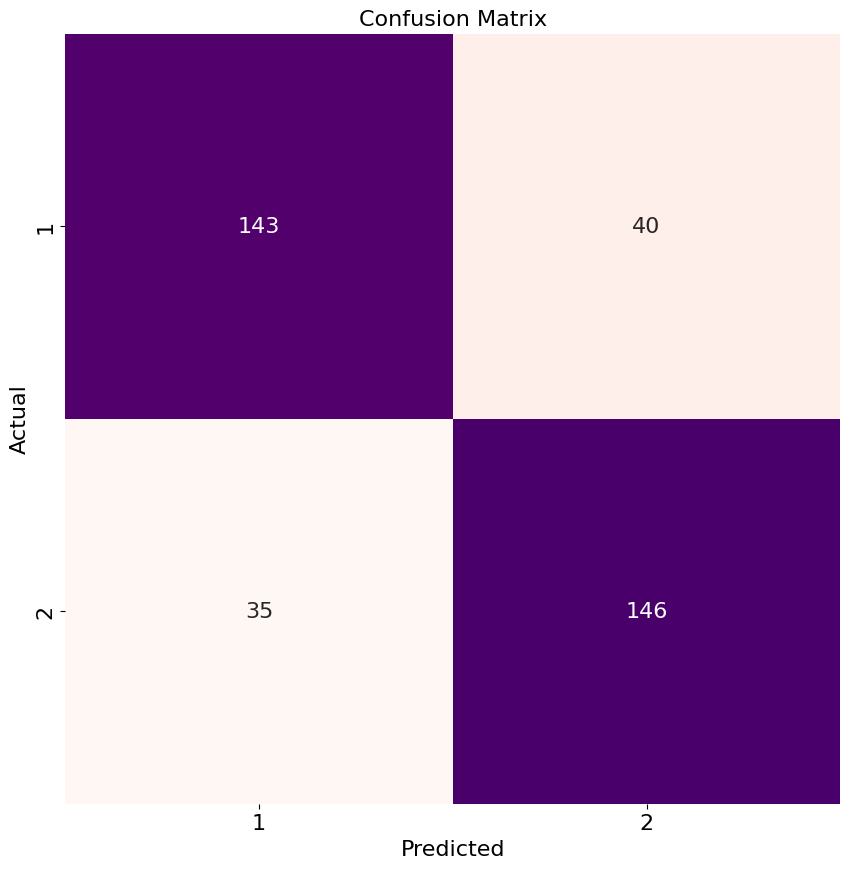

In [58]:
display_confusion_matrix(outputs_temp[1:].to('cpu'),labels_temp[1:].to('cpu'))